# DiploDatos 2019 - Análisis de Series Temporales

## Integrantes

| Nombre | e-mail |
|------|------|
|Rivadero, Isabel | isarivadero@hotmail.com |
|Vargas, Miguel | lvc0107@protonmail.com |
|Mancuso, Fernando | manquius@gmail.com |



## Introducción
En este práctico se propone explorar un dataset que contiene información de varias agencias de correo de Brasil, con el objetivo de extraer toda la información relevante sobre estos datos y presentarla de manera organizada y sencilla.
En estos datos vamos a encontrar información geográfica de los compradores y vendedores, el tipo de servicio por el que viajan los paquetes, el estado del paquete, algunas fechas relevantes y la cantidad de días hábiles que tardó el envío en llegar a su destino (target).

## Dataset

## Definiciones

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
sb.set(rc={'figure.figsize':(10.5,8.5)})

cols = ['service',
        'sender_zipcode',
        'receiver_zipcode',
        'sender_state',
        'receiver_state',
        'shipment_type',
        'quantity',
        'status',
        'date_created',
        'date_sent',
        'date_visit',
        'target']
cols_holidays = ['holiday', 
                 'description']
data_path = './shipments_BR_201903.csv'
holidays = './holidays.csv'

### Datos
Los datos que vamos a cargar son un sample no uniforme que corresponde al mes de Marzo de 2019.

In [2]:
df = pd.read_csv(data_path, usecols=cols)
df.shape

(1000000, 12)

In [3]:
df.head()

,sender_state,sender_zipcode,receiver_state,receiver_zipcode,shipment_type,quantity,service,status,date_created,date_sent,date_visit,target
0,SP,3005,SP,5409,express,1,0,done,2019-03-04 00:00:00,2019-03-05 13:24:00,2019-03-07 18:01:00,2
1,SP,17052,MG,37750,standard,1,1,done,2019-03-19 00:00:00,2019-03-20 14:44:00,2019-03-27 10:21:00,5
2,SP,2033,SP,11040,express,1,0,done,2019-02-18 00:00:00,2019-02-21 15:08:00,2019-02-28 18:19:00,5
3,SP,13900,SP,18500,express,1,0,done,2019-03-09 00:00:00,2019-03-11 15:48:00,2019-03-12 13:33:00,1
4,SP,4361,RS,96810,express,1,0,done,2019-03-08 00:00:00,2019-03-12 08:19:00,2019-03-16 08:24:00,4


#### Referencia de las columnas
* **service**: Identificador unico que corresponde a un tipo de servicio de un correo en particular.
* **sender_zipcode:** Código postal de quien envía el paquete (usualmente el vendedor).
* **receiver_zipcode:** Código postal de quien recibe el paquete (usualmente el comprador).
* **sender_state:** Nombre abreviado del estado de quien envía el paquete.
* **receiver_state:** Nombre abreviado del estado de quien recibe el paquete.
* **quantity:** Cantidad de items que tiene dentro el paquete.
* **status:** Estado final del envío.
* **date_created:** Fecha de compra de el o los items.
* **date_sent:** Fecha en que el correo recibe el paquete.
* **date_visit:** Fecha en que el correo entrega el paquete.
* **target:** Cantidad de dias hábiles que tardó el correo en entregar el paquete desde que lo recibe.


#### Feriados

In [4]:
df_h = pd.read_csv(holidays, usecols=cols_holidays)
df_h.shape

(26, 2)

In [5]:
df_h.sample(5)

,holiday,description
19,2019-07-08,Data Magna do Estado de São Paulo
22,2019-11-01,Finados
0,2019-02-12,Carnaval
8,2019-11-14,Proclamação da República
24,2019-12-30,Noche vieja


# 1. Información general

**1.1 Cantidad y proporción de envíos, servicios, tipos de envíos y rutas (consideramos como ruta la tripla zipcode, zipcode, servicio).**


In [6]:
services = pd.unique(df['service']).tolist()
print(f"Cantidad de servicios: {len(services)}")

Cantidad de servicios: 12


In [7]:
print(f"Cantidad de envíos: {len(df)}")

Cantidad de envíos: 1000000


In [8]:
df['service'].value_counts()

1     501509
0     321839
4      58517
2      49185
3      22057
5      20116
6      17602
8       5288
9       3224
7        528
10       134
11         1
Name: service, dtype: int64

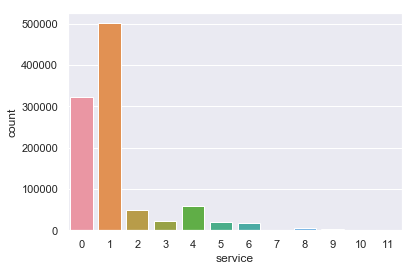

In [9]:
sb.countplot(data=df, x='service')

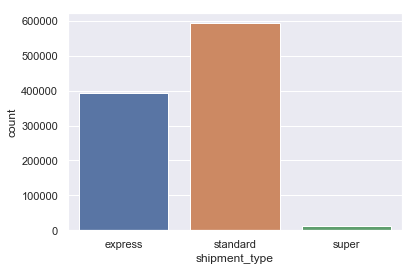

In [10]:
sb.countplot(data=df, x='shipment_type')

In [11]:
routes = pd.DataFrame(df, columns=['sender_zipcode', 'receiver_zipcode', 'service']).copy()
routes = routes.sort_values(by=['service']).copy()
routes = routes.drop_duplicates()
print(f"Cantidad de rutas: {len(routes)}")

Cantidad de rutas: 945777


In [12]:
routes.head()


,sender_zipcode,receiver_zipcode,service
0,3005,5409,0
740868,9580,41720,0
320312,14070,59700,0
740871,3572,4616,0
320310,4904,17022,0


In [13]:
routes_by_services = [route for _ , route in routes.groupby(routes['service'])]


**Cantidad de rutas utilizadas por cada servicio:**

In [14]:
# Creating an empty Dataframe with column names only
df_routes = pd.DataFrame(columns=['service', 'amount_routes'], dtype=int)

for service_id, service in enumerate(routes_by_services):
    df_routes = df_routes.append({'service': service_id, 'amount_routes': len(service)}, ignore_index=True)
df_routes

,service,amount_routes
0,0,306987
1,1,484204
2,2,44452
3,3,20485
4,4,53117
5,5,18632
6,6,8970
7,7,505
8,8,5145
9,9,3145


**1.2 Puntos máximos y mínimos de cada feature.**


In [15]:
df['target'].describe()

count    1000000.000000
mean           6.021577
std            5.157973
min            0.000000
25%            2.000000
50%            4.000000
75%            9.000000
max          118.000000
Name: target, dtype: float64

In [16]:
print(f"Primera fecha de creación envío: {df['date_created'].min()}")
print(f"Ultima fecha de creación envío: {df['date_created'].max()}")

print(f"Primera fecha de envío: {df['date_sent'].min()}")
print(f"Ultima fecha de envío: {df['date_sent'].max()}")
      
print(f"Primera fecha de entrega del envío: {df['date_visit'].min()}")
print(f"Ultima fecha de entregaa del envío: {df['date_visit'].max()}")
      

Primera fecha de creación envío: 2018-09-26 00:00:00
Ultima fecha de creación envío: 2019-06-28 00:00:00
Primera fecha de envío: 2018-10-01 16:55:00
Ultima fecha de envío: 2019-03-29 07:06:00
Primera fecha de entrega del envío: 2019-02-28 00:03:00
Ultima fecha de entregaa del envío: 2019-03-29 23:31:00


**1.3 Calcular estadísticos como la media, mediana, desviación estándar y percentiles del
target.**

In [17]:
print(f"Valor minimo: {df['target'].min()}")
print(f"Valor maximo: {df['target'].max()}")
print(f"Media: {df['target'].mean()}")
print(f"Dev std: {df['target'].std()}")
print(f"Mediana: {df['target'].median()}")
      

Valor minimo: 0
Valor maximo: 118
Media: 6.021577
Dev std: 5.157973055157452
Mediana: 4.0


**1.4 Graficar la distribución del target ¿Responde a alguna distribución conocida?**


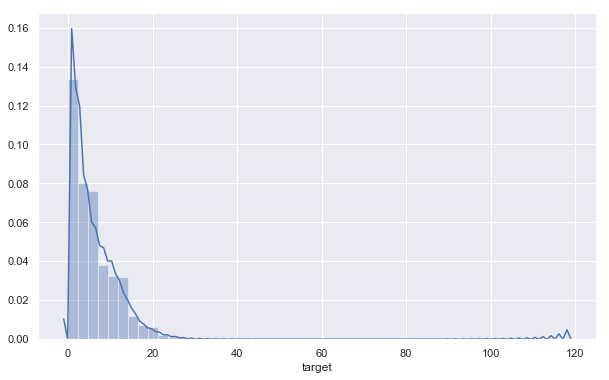

In [18]:
plt.figure(figsize=(10,6))
sb.distplot(df['target'])

In [19]:
from scipy.stats import expon, kstest
kstest(df['target'], expon(scale=1.0 / df['target'].mean()).cdf)

KstestResult(statistic=0.9764561589743064, pvalue=0.0)

**1.5 Graficar solo la parte más informativa de la distribución del target , teniendo cuidado
con elegir correctamente los parámetros de los gráficos, como la cantidad de bins en
un histograma.**


**1.6 Identificar y graficar outliers. ¿Son significativos?**


**1.7 ¿Los fines de semana son diferentes a los días de semana? ¿En qué sentido?**


**1.8 ¿Existe algún periodo de tiempo diferente a los demás? Comparar gráficamente las
distribuciones de los targets (Puede ayudar utilizar información externa).**


**1.9 Observando la distribución del target semana a semana. Explicar que sucede y cuál
puede ser la razón. Graficar las distribuciones en conjunto o la diferencia entre ellas.**


**1.10 ¿Existen rutas más representadas que otras?**


**1.11 La cantidad de items por paquete, ¿tiene relación con la velocidad del envío?**


**1.12 ¿Existen variables correlacionadas?**


**1.13 Graficar la distribución del target agrupando por tipo de envío.**


**1.14 Determinar cuales son los servicios y los estados más representados**


# 2. Servicios

**2.1 Graficar solo la parte más informativa de la distribución del target para los 4
servicios más representados, con los cuidados correspondientes.**


**2.2 ¿Existen servicios más rápidos que otros?**


**2.3 ¿Existen servicios similares entre sí? ¿Alguna idea de porque?**


**2.4 (Extra) ¿Podrías identificar cuántos correos aparecen en los datos?**


# 3. Estados

**3.1 Graficar solo la parte más informativa de la distribución del target para los 4 estados
más representados, con los cuidados correspondientes.**


Buscamos cuales son los 4 estados mas representados utilizando 'receiver_state'

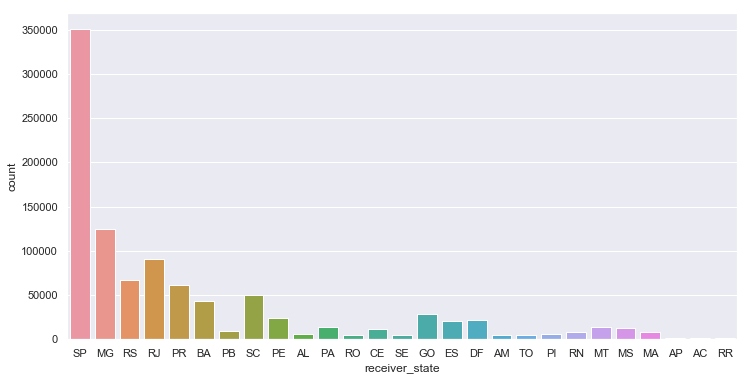

In [20]:
plt.figure(figsize=(12,6))
sb.countplot(data=df, x='receiver_state')

Observamos que los 4 estados mas representados son "SP", "MG", "RS" y "RJ". Filtramos nuestro dataset para esos 4 estados.

In [21]:
filtered_states = df[df['receiver_state'].isin(["SP", "MG", "RS", "RJ"])]

Graficamos la distribucion de 'target' en un boxplot, para identificar los valores que pueden considerarse outliers

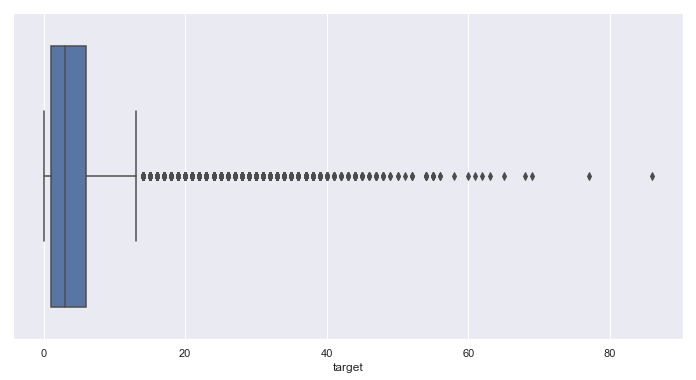

In [22]:
plt.figure(figsize=(12,6))
sb.boxplot(filtered_states['target'])

Graficamos la distribucion de los targets eliminando los outliers superiores a 15

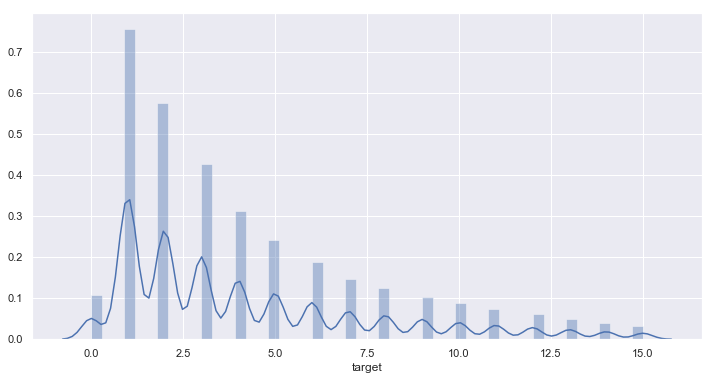

In [23]:
targets = filtered_states[filtered_states['target'] <= 15]['target']
plt.figure(figsize=(12,6))
sb.distplot(targets)

**3.2 ¿Cómo están distribuidos los vendedores geográficamente?**


Graficamos el conteo de 'sender_state'

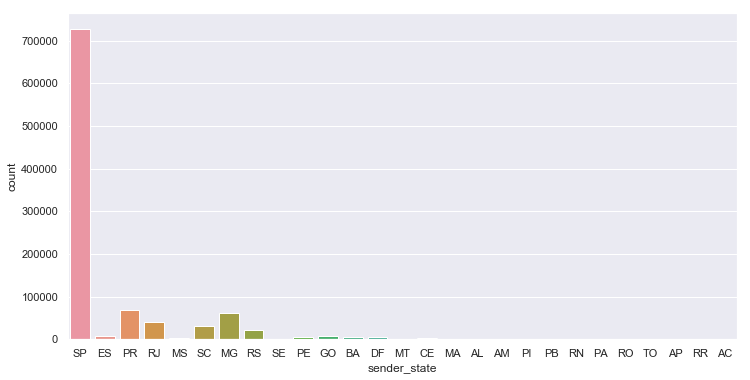

In [24]:
plt.figure(figsize=(12,6))
sb.countplot(data=df, x='sender_state')

Observamos una muy alta concentracion de vendedores en el estado 'SP'. Con una participacion casi despreciable en los demas estados, destacandose entre estos 'PR', 'RJ', 'SC', 'MG' y 'RS'.

**3.3 ¿Cómo es la participación de los servicios dentro y fuera de San Pablo?**


Graficamos el conteo de servicios en 'SP'

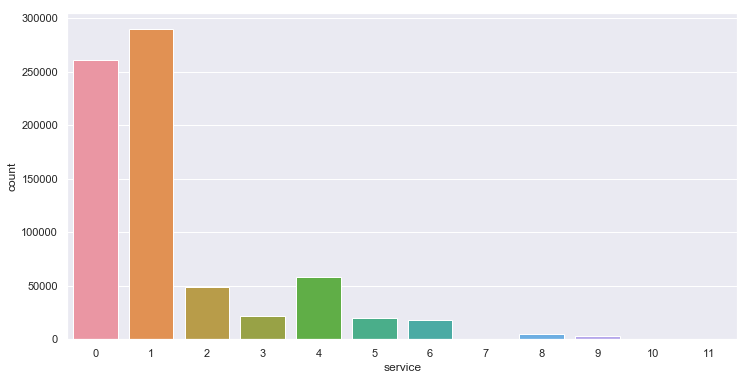

In [25]:
sp=df[df['sender_state'] == 'SP']
plt.figure(figsize=(12,6))
sb.countplot(data=sp, x='service')

Graficamos ahora los servicios fuera de 'SP'

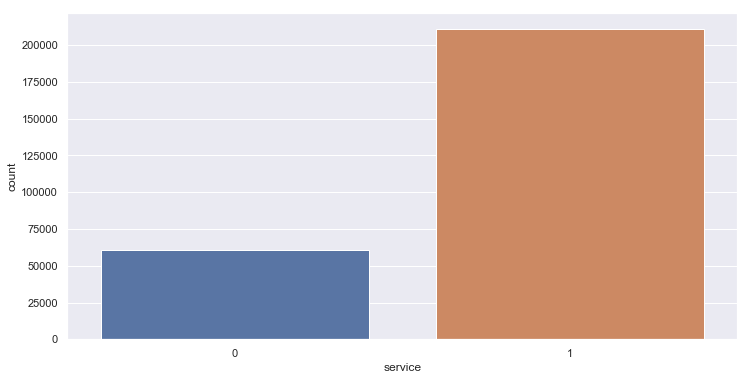

In [26]:
no_sp=df[df['sender_state'] != 'SP']
plt.figure(figsize=(12,6))
sb.countplot(data=no_sp, x='service')

Observamos que fuera de San Pablo, la oferta de servicios es mucho mas limitada. Llegando unicamente los dos servicios mas grandes del pais.

**3.4 (Extra) ¿Podrías explicar porque estos estados están más representados que los
otros?.**


Segun [Wikipedia](https://en.wikipedia.org/wiki/List_of_Brazilian_states_by_population). San Pablo concentra el 21% de la poblacion de Brasil, siendo equivalente a la poblacon total de Argentina. Superando el doble del siguiente estado, Minas Gerais.

**3.5 Realizar un mapa de calor utilizando los zipcodes de los vendedores y los
compradores.**


In [ ]:
exp = df[df['sender_state'].isin(["SP", "MG", "RS", "RJ"])]
exp = exp[['sender_zipcode', 'receiver_zipcode']]
exp = exp.pivot_table(index='sender_zipcode', columns='receiver_zipcode', aggfunc=len, fill_value=0)
plt.figure(figsize=(12,6))
sb.heatmap(exp, robust=True, linewidths=0, vmin=0, vmax=5, annot=True, fmt="d")

**3.6 ¿Cual es la relación entre los zipcodes y los estados?**


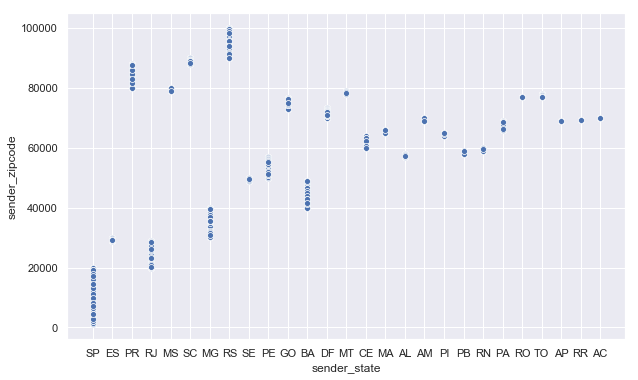

In [28]:
plt.figure(figsize=(10,6))
sb.scatterplot(data=df,
                    x='sender_state',
                    y='sender_zipcode')

Se espera que utilicen las preguntas como guía de lo que se espera que vean en los datos,
todas las respuestas tienen que estar justificadas con datos o gráficos. Se evaluará la
legibilidad del notebook, el detalle a la hora de responder las preguntas y mostrar la
información solicitada, y además que los gráficos utilizados sean apropiados y correctos. La
información no contemplada en las preguntas que se logre encontrar y presentar
correctamente será valorada.

# 4. Conclusion